In [1]:
# Google 드라이브를 마운트하려면 이 셀을 실행하세요.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install surprise

     |████████████████████████████████| 3.3MB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [3]:
import pandas as pd
import numpy as np
import os
os.listdir('./drive/My Drive/colab/recsys/data')

['test.csv',
 'train.csv',
 'item_metadata.csv',
 'submission_popular.csv',
 'reference_first.pkl',
 'df_ref.csv',
 'dwell_df.csv',
 'df_full_except_noinfo.csv',
 'dwell_sec_bo_pred.csv',
 'dwell_sec_bo_pred_submission.csv',
 'baseline_sorting.csv',
 'dwell_sec_svd_pred.csv']

In [4]:
path = './drive/My Drive/colab/recsys/data/'
dwell_df = pd.read_csv(path + 'dwell_df.csv')
#dwell_df.reference = dwell_df.reference.astype(str)
dwell_df.head()

,user_id,reference,dwell_sec,log_dwell_sec,dwell_min,log_dwell_min
0,0001VQMGUI65,2019467,69,4.248495,1.150000,0.765468
1,0001VQMGUI65,3133074,386,5.958425,6.433333,2.005974
2,0001VQMGUI65,4521140,516859,13.155527,8614.316667,9.061297
3,0001VQMGUI65,477811,2,1.098612,0.033333,0.032790
4,0001VQMGUI65,950829,12,2.564949,0.200000,0.182322


In [0]:
dwell_df[['dwell_sec','log_dwell_sec','dwell_min','log_dwell_min']].describe()

,dwell_sec,log_dwell_sec,dwell_min,log_dwell_min
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,4.451140e+04,5.947687e+00,7.418567e+02,2.410327e+00
std,1.146012e+05,3.229499e+00,1.910020e+03,2.828640e+00
min,1.000000e+00,6.931472e-01,1.666667e-02,1.652930e-02
25%,4.400000e+01,3.806662e+00,7.333333e-01,5.500463e-01
50%,1.210000e+02,4.804021e+00,2.016667e+00,1.104152e+00
75%,7.920000e+02,6.675823e+00,1.320000e+01,2.653242e+00
max,1.511802e+06,1.422881e+01,2.519670e+04,1.013451e+01


In [0]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise import NormalPredictor
#from surprise import KNNBasic,KNNWithMeans,KNNWithZScore,KNNBaseline #memory error
from surprise import SVD, SVDpp, NMF
from surprise import BaselineOnly, CoClustering
from surprise import NormalPredictor
from surprise.accuracy import rmse
from surprise import accuracy

# dwell sec

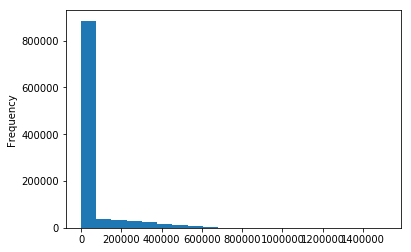

In [0]:
dwell_df.dwell_sec.plot.hist(bins = 20)

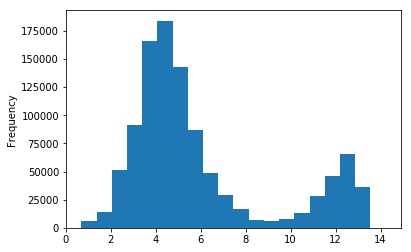

In [0]:
dwell_df.log_dwell_sec.plot.hist(bins = 20)

In [0]:
reader = Reader(rating_scale=(0,15))
data = Dataset.load_from_df(dwell_df[['user_id','reference','log_dwell_sec']], reader)

In [0]:
benchmark = []

### algorithms

In [0]:
for algo in [SVD(), SVDpp(), NMF(), BaselineOnly(), CoClustering(), NormalPredictor()] :
  name = str(algo).split(' ')[0].split('.')[-1]
  print('algorithm : ', name)
  results = cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv = 3, verbose = False)

  #get results
  tmp = pd.DataFrame.from_dict(results).mean(axis = 0)
  tmp = tmp.append(pd.Series(name, index = ['Algorithm']))
  benchmark.append(tmp)

algorithm :  SVD
algorithm :  SVDpp
algorithm :  NMF
algorithm :  BaselineOnly
algorithm :  CoClustering
algorithm :  NormalPredictor


In [0]:
benchmark = pd.DataFrame(benchmark)
benchmark

,test_rmse,test_mae,fit_time,test_time,Algorithm
0,3.212320,2.458142,66.149542,4.860370,SVD
1,3.212291,2.458476,66.022070,5.034865,SVDpp
2,3.212682,2.458432,65.880181,4.856009,NMF
3,3.212797,2.458610,66.079578,5.167711,BaselineOnly
4,3.212731,2.458957,65.782783,4.712536,CoClustering
5,3.213331,2.459143,65.916693,4.910359,NormalPredictor


# predict

In [0]:
sub = pd.read_csv(path + 'submission_popular.csv')
sub.shape

(253573, 5)

In [0]:
uni = dwell_df.user_id.unique()
sub['is_in'] = sub.user_id.apply(lambda x : x in uni)
sub.head()

,user_id,session_id,timestamp,step,item_recommendations,isin
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 105...,True
1,0004Q49X39PY,9de47d9a66494,1541641157,1,3505150 3812004 2227896 2292254 3184842 222702...,False
2,0004Q49X39PY,beea5c27030cb,1541561202,1,4476010 3505150 3812004 2227896 2292254 222702...,False
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22854 3067559 22721 22713 16121 22772 22727 22...,True
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,9857656 5849628 655716 1352530 502066 1405084 ...,True


In [0]:
testset = sub[sub.is_in == True]
testset.shape


(89372, 6)

In [0]:
testset.head()

,user_id,session_id,timestamp,step,item_recommendations,is_in
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 105...,True
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22854 3067559 22721 22713 16121 22772 22727 22...,True
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,9857656 5849628 655716 1352530 502066 1405084 ...,True
5,000GO9NY6P4M,55dbafdbb9bab,1541594662,2,160577 157710 1618677 7231396 483691 1479743 1...,True
6,000IRHJS2DL9,f6ffffd20d43d,1541605541,12,33191 20144 20166 20154 3054956 346166 102540 ...,True


## BaselineONly

In [0]:
trainset = data.build_full_trainset()
algo = BaselineOnly()
fitting = algo.fit(trainset)

Estimating biases using als...


In [0]:
item_unique = dwell_df.reference.unique()

266916

In [0]:
pred = []
i = 0
for user in testset.user_id :
  i+=1
  if i%1000 == 0 :
    print('{}번째 id'.format(i))
    
  iid = sub[sub.user_id == user]['item_recommendations'].values[0].split(' ')
  iid = list(map(int, iid))
  
  for item in iid :
    if item in item_unique :
      algo_pred = algo.predict(user, item)
      pred.append(algo_pred)

1000번째 id
2000번째 id
3000번째 id
4000번째 id
5000번째 id
6000번째 id
7000번째 id
8000번째 id
9000번째 id
10000번째 id
11000번째 id
12000번째 id
13000번째 id
14000번째 id
15000번째 id
16000번째 id
17000번째 id
18000번째 id
19000번째 id
20000번째 id
21000번째 id
22000번째 id
23000번째 id
24000번째 id
25000번째 id
26000번째 id
27000번째 id
28000번째 id
29000번째 id
30000번째 id
31000번째 id
32000번째 id
33000번째 id
34000번째 id
35000번째 id
36000번째 id
37000번째 id
38000번째 id
39000번째 id
40000번째 id
41000번째 id
42000번째 id
43000번째 id
44000번째 id
45000번째 id
46000번째 id
47000번째 id
48000번째 id
49000번째 id
50000번째 id
51000번째 id
52000번째 id
53000번째 id
54000번째 id
55000번째 id
56000번째 id
57000번째 id
58000번째 id
59000번째 id
60000번째 id
61000번째 id
62000번째 id
63000번째 id
64000번째 id
65000번째 id
66000번째 id
67000번째 id
68000번째 id
69000번째 id
70000번째 id
71000번째 id
72000번째 id
73000번째 id
74000번째 id
75000번째 id
76000번째 id
77000번째 id
78000번째 id
79000번째 id
80000번째 id
81000번째 id
82000번째 id
83000번째 id
84000번째 id
85000번째 id
86000번째 id
87000번째 id
88000번째 id
89000번째 id


In [0]:
pred = pd.DataFrame(pred)
pred.shape

(1685856, 5)

In [0]:
pred = pred[['uid','iid','est']]
pred.head()

,uid,iid,est
0,000324D9BBUC,924795,5.919184
1,000324D9BBUC,106315,5.356635
2,000324D9BBUC,1033140,6.900042
3,000324D9BBUC,119494,6.035513
4,000324D9BBUC,101758,5.665318


In [0]:
pred = pred.groupby('uid').apply(lambda x : x.sort_values(['est'], ascending = False)).reset_index(drop = True)

In [0]:
pred.iid = pred.iid.apply(str)
pred = pred.groupby('uid')['iid'].apply(lambda x : ' '.join(x)).to_frame().reset_index()

In [0]:
#pred.to_csv(path + 'dwell_sec_bo_pred.csv', index = False)
pred.head()

,uid,iid
0,000324D9BBUC,1033140 97170 147907 119494 924795 101758 3531...
1,00071784XQ6B,22772 22854 4082698 150825 45096 102569 22798 ...
2,0008BO33KUQ0,1888653 977727 9857656 507861 4984730 1887759 ...
3,000GO9NY6P4M,157710 1287958 160577 483691 1479743 6120442 1...
4,000IRHJS2DL9,346166 102540 20154 20144 20166 2285010 254784...


In [0]:
pred_id = pred.uid

In [0]:
sub = pd.merge(sub, pred, how = 'left', left_on='user_id',right_on='uid').drop('uid', axis = 1)
sub.head()

,user_id,session_id,timestamp,step,item_recommendations,is_in,iid
0,000324D9BBUC,89643988fdbfb,1541593942,10,924795 106315 1033140 119494 101758 903037 105...,True,1033140 97170 147907 119494 924795 101758 3531...
1,0004Q49X39PY,9de47d9a66494,1541641157,1,3505150 3812004 2227896 2292254 3184842 222702...,False,NaN
2,0004Q49X39PY,beea5c27030cb,1541561202,1,4476010 3505150 3812004 2227896 2292254 222702...,False,NaN
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22854 3067559 22721 22713 16121 22772 22727 22...,True,22772 22854 4082698 150825 45096 102569 22798 ...
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,9857656 5849628 655716 1352530 502066 1405084 ...,True,1888653 977727 9857656 507861 4984730 1887759 ...


In [0]:
sub.item_recommendations.loc[sub.is_in == True] = sub.iid.loc[sub.is_in == True]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
sub = sub.iloc[:,:5]

In [0]:
#sub.to_csv(path + 'dwell_sec_bo_pred_submission.csv', index = False)

## SVD

In [0]:
trainset = data.build_full_trainset()
algo = SVD()
fitting = algo.fit(trainset)

In [8]:
baseline_sub = pd.read_csv(path + 'baseline_sorting.csv')
baseline_sub.head()

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,1000915 1241375 923407 1729121 1050792 97171 3...
1,0004Q49X39PY,beea5c27030cb,1541561202,1,3812004 3505150 3202894 2292254 1984229 222789...
2,0004Q49X39PY,9de47d9a66494,1541641157,1,2213014 3184842 10213134 4504242 4486372 38120...
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22721 3067559 16121 22727 22854 22819 22764 14...
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,507861 2176280 1669587 502066 1352530 4342348 ...


In [0]:
uni = dwell_df.user_id.unique()

In [10]:

baseline_sub['is_in'] = baseline_sub.user_id.apply(lambda x : x in uni)
baseline_sub.head()


,user_id,session_id,timestamp,step,item_recommendations,is_in
0,000324D9BBUC,89643988fdbfb,1541593942,10,1000915 1241375 923407 1729121 1050792 97171 3...,True
1,0004Q49X39PY,beea5c27030cb,1541561202,1,3812004 3505150 3202894 2292254 1984229 222789...,False
2,0004Q49X39PY,9de47d9a66494,1541641157,1,2213014 3184842 10213134 4504242 4486372 38120...,False
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22721 3067559 16121 22727 22854 22819 22764 14...,True
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,507861 2176280 1669587 502066 1352530 4342348 ...,True


In [0]:
item_unique = dwell_df.reference.unique()

In [12]:
testset = baseline_sub[baseline_sub.is_in == True]
testset.shape

(89372, 6)

In [13]:
pred = []
i = 0
for user in testset.user_id :
  i+=1
  if i%10000 == 0 :
    print('{}번째 id'.format(i))
    
  iid = baseline_sub[baseline_sub.user_id == user]['item_recommendations'].values[0].split(' ')
  iid = list(map(int, iid))
  
  for item in iid :
    if item in item_unique :
      algo_pred = algo.predict(user, item)
      pred.append(algo_pred)

10000번째 id


KeyboardInterrupt: ignored

In [0]:
pred = pd.DataFrame(pred)
pred.shape

In [0]:
pred = pred[['uid','iid','est']]
pred.head()

In [0]:
pred = pred.groupby('uid').apply(lambda x : x.sort_values(['est'], ascending = False)).reset_index(drop = True)
pred.iid = pred.iid.apply(str)

In [0]:
#pred.to_csv(path + 'dwell_sec_svd_pred.csv', index = False)
pred = pd.read_csv(path + 'dwell_sec_svd_pred.csv')
pred.iid = pred.iid.apply(str)

In [38]:
first_pred = pred.groupby('uid')['iid'].first().to_frame().reset_index()
first_pred.iid = first_pred.iid.apply(str)
first_pred = first_pred.rename(columns={'iid' : 'pred_first'})
first_pred.head()

,uid,pred_first
0,000324D9BBUC,1033140
1,00071784XQ6B,22772
2,0008BO33KUQ0,977727
3,000GO9NY6P4M,157710
4,000IRHJS2DL9,20154


In [40]:
join_pred = pred.groupby('uid')['iid'].apply(lambda x : ' '.join(x)).to_frame().reset_index()
join_pred = pd.merge(join_pred, first_pred)
join_pred.head()

,uid,iid,pred_first
0,000324D9BBUC,1033140 147907 924795 97170 119494 353141 1017...,1033140
1,00071784XQ6B,22772 22854 45096 4082698 3067559 22713 22764 ...,22772
2,0008BO33KUQ0,977727 9857656 1888653 1352530 4984730 1669587...,977727
3,000GO9NY6P4M,157710 1287958 7231396 160577 6120442 483691 1...,157710
4,000IRHJS2DL9,20154 102540 346166 20166 33191 20144 3054956 ...,20154


In [41]:
baseline_sub = pd.merge(baseline_sub, join_pred, how = 'left', left_on='user_id', right_on='uid').drop('uid', axis = 1)
baseline_sub.head()


,user_id,session_id,timestamp,step,item_recommendations,is_in,iid,pred_first
0,000324D9BBUC,89643988fdbfb,1541593942,10,1000915 1241375 923407 1729121 1050792 97171 3...,True,1033140 147907 924795 97170 119494 353141 1017...,1033140
1,0004Q49X39PY,beea5c27030cb,1541561202,1,3812004 3505150 3202894 2292254 1984229 222789...,False,NaN,NaN
2,0004Q49X39PY,9de47d9a66494,1541641157,1,2213014 3184842 10213134 4504242 4486372 38120...,False,NaN,NaN
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22721 3067559 16121 22727 22854 22819 22764 14...,True,22772 22854 45096 4082698 3067559 22713 22764 ...,22772
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,507861 2176280 1669587 502066 1352530 4342348 ...,True,977727 9857656 1888653 1352530 4984730 1669587...,977727


In [0]:
def sort_again(item_reco, first, iid) :
  a = item_reco.split(' ')[0]
  if a == first :
    return iid
  else :
    try :
      b = str(iid).split(' ')
      b.remove(a)
      return ' '.join([a] + b)
    except :
      return item_reco

In [43]:
baseline_sub.item_recommendations.loc[baseline_sub.is_in == True] = baseline_sub[baseline_sub.is_in == True].apply(lambda x : sort_again(x['item_recommendations'], x['pred_first'], x['iid']), axis = 1)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
baseline_sub = baseline_sub.iloc[:,:5]
baseline_sub.to_csv(path + 'baseline_add_SVD_sub.csv', index = False)

In [0]:
baseline_sub.head(3)

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,1000915 1033140 147907 924795 97170 119494 353...
1,0004Q49X39PY,beea5c27030cb,1541561202,1,3812004 3505150 3202894 2292254 1984229 222789...
2,0004Q49X39PY,9de47d9a66494,1541641157,1,2213014 3184842 10213134 4504242 4486372 38120...


In [0]:
sub = pd.read_csv(path + 'baseline_sorting.csv')
sub.head()

,user_id,session_id,timestamp,step,item_recommendations
0,000324D9BBUC,89643988fdbfb,1541593942,10,1000915 1241375 923407 1729121 1050792 97171 3...
1,0004Q49X39PY,beea5c27030cb,1541561202,1,3812004 3505150 3202894 2292254 1984229 222789...
2,0004Q49X39PY,9de47d9a66494,1541641157,1,2213014 3184842 10213134 4504242 4486372 38120...
3,00071784XQ6B,9617600e1ba7c,1541630328,2,22721 3067559 16121 22727 22854 22819 22764 14...
4,0008BO33KUQ0,2d0e2102ee0dc,1541636411,6,507861 2176280 1669587 502066 1352530 4342348 ...
